# Process data particles

In [58]:
# Libraries ----
import sys  # type: ignore
import imageio  # type: ignore
import warnings
import numpy as np  # type: ignore
import pandas as pd  # type: ignore

sys.path.append('../modules')
import track_particles as tp  # type: ignore
import plot_tracking as plt_tp  # type: ignore
import plot_smoothing as plt_sp  # type: ignore
import plot_clustering as plt_cp  # type: ignore
import smoothing_particles as sp  # type: ignore

# Global options ----
warnings.filterwarnings("ignore")
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', None)

## Global variables

In [18]:
input_path = "../input_files"
output_path = "../output_files"
log_path = "../logs"
input_generation_date = "2024-10-24"

n_particles = 4
ordering = False
video_name = "23_05_23_3_1080"
x_bounds = [40, 1020]
y_bounds = [160, 1740]
x_zoom = [760, 1000]
y_zoom = [1500, 1720]

## Setting video information

In [3]:
# Load the video
reader = imageio.get_reader("{}/{}.mp4".format(input_path, video_name), "ffmpeg")

# Check the number of frames
num_frames = reader.count_frames()
print("Total frames: {}".format(num_frames))

# Extract a frame to inspect the content
time = 0
frame = reader.get_data(time)
print("Frames resolution: {} x {}".format(frame.shape[0], frame.shape[1]))

Total frames: 90650
Frames resolution: 1080 x 1920


## Load tracked data

In [7]:
df_times = pd.read_csv("{}/filtering_{}.csv".format(input_path, video_name), low_memory=False)
df_times[df_times["dropped_frame"] == True]

,time,dropped_frame
130,130,True
271,271,True
286,286,True
287,287,True
288,288,True
...,...,...
29618,29622,True
29619,29623,True
32329,32335,True
84740,85599,True


In [4]:
df_tracked = pd.read_csv("{}/clustered_{}.csv".format(output_path, video_name), low_memory=False)
df_tracked.head(n_particles)

,id,time,position_x,position_y,weighted_x,weighted_y,darkest_v,darkest_x,darkest_y,lightest_v,lightest_x,lightest_y,orientation,area,area_convex,area_filled,axis_major,axis_minor,eccentricity,euler_number,id_count,velocity_x,velocity_y,velocity_orientation,mask_x,mask_y,mask_orientation
0,0,0,131.361102,277.047904,129.820192,282.752376,NaN,131.361102,277.047904,NaN,131.361102,277.047904,-0.284792,9039.0,12978.0,9050.0,196.579324,71.364684,0.931776,-38,4,NaN,NaN,NaN,False,False,False
1,1,0,456.948442,377.037307,457.656262,377.513295,0.0,503.000000,333.000000,0.627451,476.000000,345.000000,-1.279919,8631.0,12656.0,8636.0,165.988477,72.910703,0.898364,-22,4,NaN,NaN,NaN,False,False,False
2,2,0,164.068444,499.940035,167.470318,504.772246,NaN,164.068444,499.940035,NaN,164.068444,499.940035,0.738668,9789.0,12576.0,9829.0,187.418000,74.960595,0.916531,-20,4,NaN,NaN,NaN,False,False,False
3,3,0,1455.613066,823.843911,1456.773911,830.276236,0.0,1445.000000,738.000000,0.458824,1447.000000,749.000000,0.155444,9123.0,10618.0,9917.0,190.276157,68.388433,0.933177,-25,4,NaN,NaN,NaN,False,False,False


In [9]:
df_tracked = df_tracked[~df_tracked["time"].isin(df_times[df_times["dropped_frame"] == True]["time"].unique())]

## Swapping mixed IDs

In [19]:
omega_threshold = df_tracked["velocity_orientation"].abs().quantile(0.9965) # Angular velocity per frame
velocity_threshold = df_tracked["velocity_x"].abs().quantile(0.9701) # Velocity per frame limited with half average size of particle
t0, tf = 0, 30200  # 0, num_frames
print("Thresholds:\n\t- Velocity:", velocity_threshold, "\n\t- Angle:", omega_threshold * 180 / np.pi)

if ordering:
    df_smooth = sp.smooth_evolution(
        df_tracked=df_tracked[(df_tracked["time"] >= t0) & (df_tracked["time"] <= tf)],
        velocity_threshold=velocity_threshold,
        omega_threshold=omega_threshold
    )

Thresholds:
	- Velocity: 18.852874321718346 
	- Angle: 161.61634747228754
Previous Time: 0 Current Time: 1 mask_x: False mask_y: False Final mask: True
Previous Time: 100 Current Time: 101 mask_x: False mask_y: False Final mask: True
Previous Time: 200 Current Time: 201 mask_x: False mask_y: False Final mask: True
Previous Time: 400 Current Time: 401 mask_x: True mask_y: True Final mask: False
Previous Time: 500 Current Time: 501 mask_x: True mask_y: True Final mask: False
Previous Time: 600 Current Time: 601 mask_x: True mask_y: True Final mask: False
Previous Time: 700 Current Time: 701 mask_x: True mask_y: True Final mask: False
Previous Time: 900 Current Time: 901 mask_x: False mask_y: False Final mask: True
Previous Time: 1000 Current Time: 1001 mask_x: False mask_y: False Final mask: True
Previous Time: 1100 Current Time: 1101 mask_x: False mask_y: False Final mask: True
Previous Time: 1200 Current Time: 1201 mask_x: False mask_y: False Final mask: True
Previous Time: 1300 Curren

In [64]:
# Interpolate final positions
# if ordering:
df_times_final = pd.concat([df_times.assign(permuted_id=id_) for id_ in range(n_particles)], ignore_index=True)
df_full = df_times_final.merge(right=df_smooth, how="left", on=["time", "permuted_id"]).sort_values(["permuted_id", "time"])
#for id_ in range(len(df_full["permuted_id"].unique())):
#    mask = df_full.loc[:,"permuted_id"]==df_full["permuted_id"].unique()[id_]
#    df_full[mask]=df_full[mask].interpolate(method="linear")
df_full = df_full[df_full["time"] < tf]
df_full[df_full.time.isin([129,130,131,718,719,720,721,722,723,724,725])]

,time,dropped_frame_x,permuted_id,dropped_frame_y,id,position_x,position_y,weighted_x,weighted_y,darkest_v,darkest_x,darkest_y,lightest_v,lightest_x,lightest_y,orientation,area,area_convex,area_filled,axis_major,axis_minor,eccentricity,euler_number,id_count,velocity_x,velocity_y,velocity_orientation,mask_x,mask_y,mask_orientation
129,129,False,0,False,0.0,93.706921,509.316656,93.209723,510.667609,0.0,98.912454,474.159063,0.560784,102.912454,480.159063,0.372767,4537.0,7798.0,4540.0,163.763214,48.105237,0.955883,-11.0,4.0,7.504378,15.918533,0.231933,True,True,True
130,130,True,0,True,0.0,92.085300,513.341107,91.691114,514.238546,0.0,97.115278,479.208959,0.562745,100.865278,485.208959,0.386063,4461.5,7399.5,4464.5,154.444320,47.645304,0.950775,-13.5,4.0,2.130568,11.983717,0.129262,NaN,NaN,NaN
131,131,False,0,False,0.0,90.463679,517.365558,90.172505,517.809483,0.0,95.318102,484.258854,0.564706,98.818102,490.258854,0.399358,4386.0,7001.0,4389.0,145.125426,47.185371,0.945668,-16.0,4.0,-3.243242,8.048902,0.026591,True,True,True
718,718,False,0,False,0.0,191.086715,489.895878,192.650002,484.783236,0.0,191.086715,489.895878,0.627451,191.086715,489.895878,0.297238,1556.0,15203.0,1556.0,237.715788,88.642383,0.927875,-15.0,4.0,0.028242,0.055512,-0.001978,True,True,True
719,719,False,0,False,0.0,197.435435,472.560999,196.220993,476.635950,0.0,232.000000,377.000000,0.627451,165.000000,472.000000,0.394603,9533.0,15101.0,9545.0,225.035546,70.590898,0.949526,-30.0,4.0,6.348719,-17.334879,0.097365,True,True,True
720,720,False,0,False,0.0,196.844669,472.420718,195.518057,477.367586,0.0,196.844669,472.420718,0.625490,196.844669,472.420718,0.416589,9586.0,18169.0,9594.0,222.724605,73.316632,0.944267,-33.0,4.0,-0.590765,-0.140281,0.021986,True,True,True
721,721,False,0,False,0.0,196.132600,471.837622,194.804156,476.253295,0.0,196.132600,471.837622,0.623529,196.132600,471.837622,0.447382,9638.0,16331.0,9639.0,221.760574,71.545485,0.946527,-29.0,4.0,-0.712069,-0.583096,0.030793,True,True,True
722,722,False,0,False,0.0,195.870127,471.716192,194.587336,476.028515,0.0,195.870127,471.716192,0.621569,195.870127,471.716192,0.458501,9517.0,16322.0,9533.0,221.494901,71.500842,0.946464,-31.0,4.0,-0.262473,-0.121430,0.011119,True,True,True
723,723,False,0,False,0.0,185.992588,501.845097,186.560338,501.474540,0.0,232.293484,447.523630,0.619608,175.586969,510.047260,0.610113,7724.0,10641.0,7737.0,167.656406,62.196334,0.928643,-16.0,4.0,-9.877540,30.128905,0.151612,True,False,True
724,724,True,0,True,0.0,190.796080,486.205606,190.250154,488.270952,0.0,213.946528,459.044872,0.617647,185.593271,490.306687,0.549988,8539.5,13566.0,8553.0,193.787423,66.888826,0.937094,-27.5,4.0,-0.135277,-0.575039,0.015681,NaN,NaN,NaN


In [45]:
if ordering:
    df_temp = df_full[["id", "permuted_id", "time", "position_x", "position_y", "orientation"]]
    df_temp.to_csv("{}/interpolated_{}.csv".format(output_path, video_name), index=False)
    df_temp

Thresholds:
	- Velocity: 18.977552158256913 
	- Angle: 134.50918303366484 



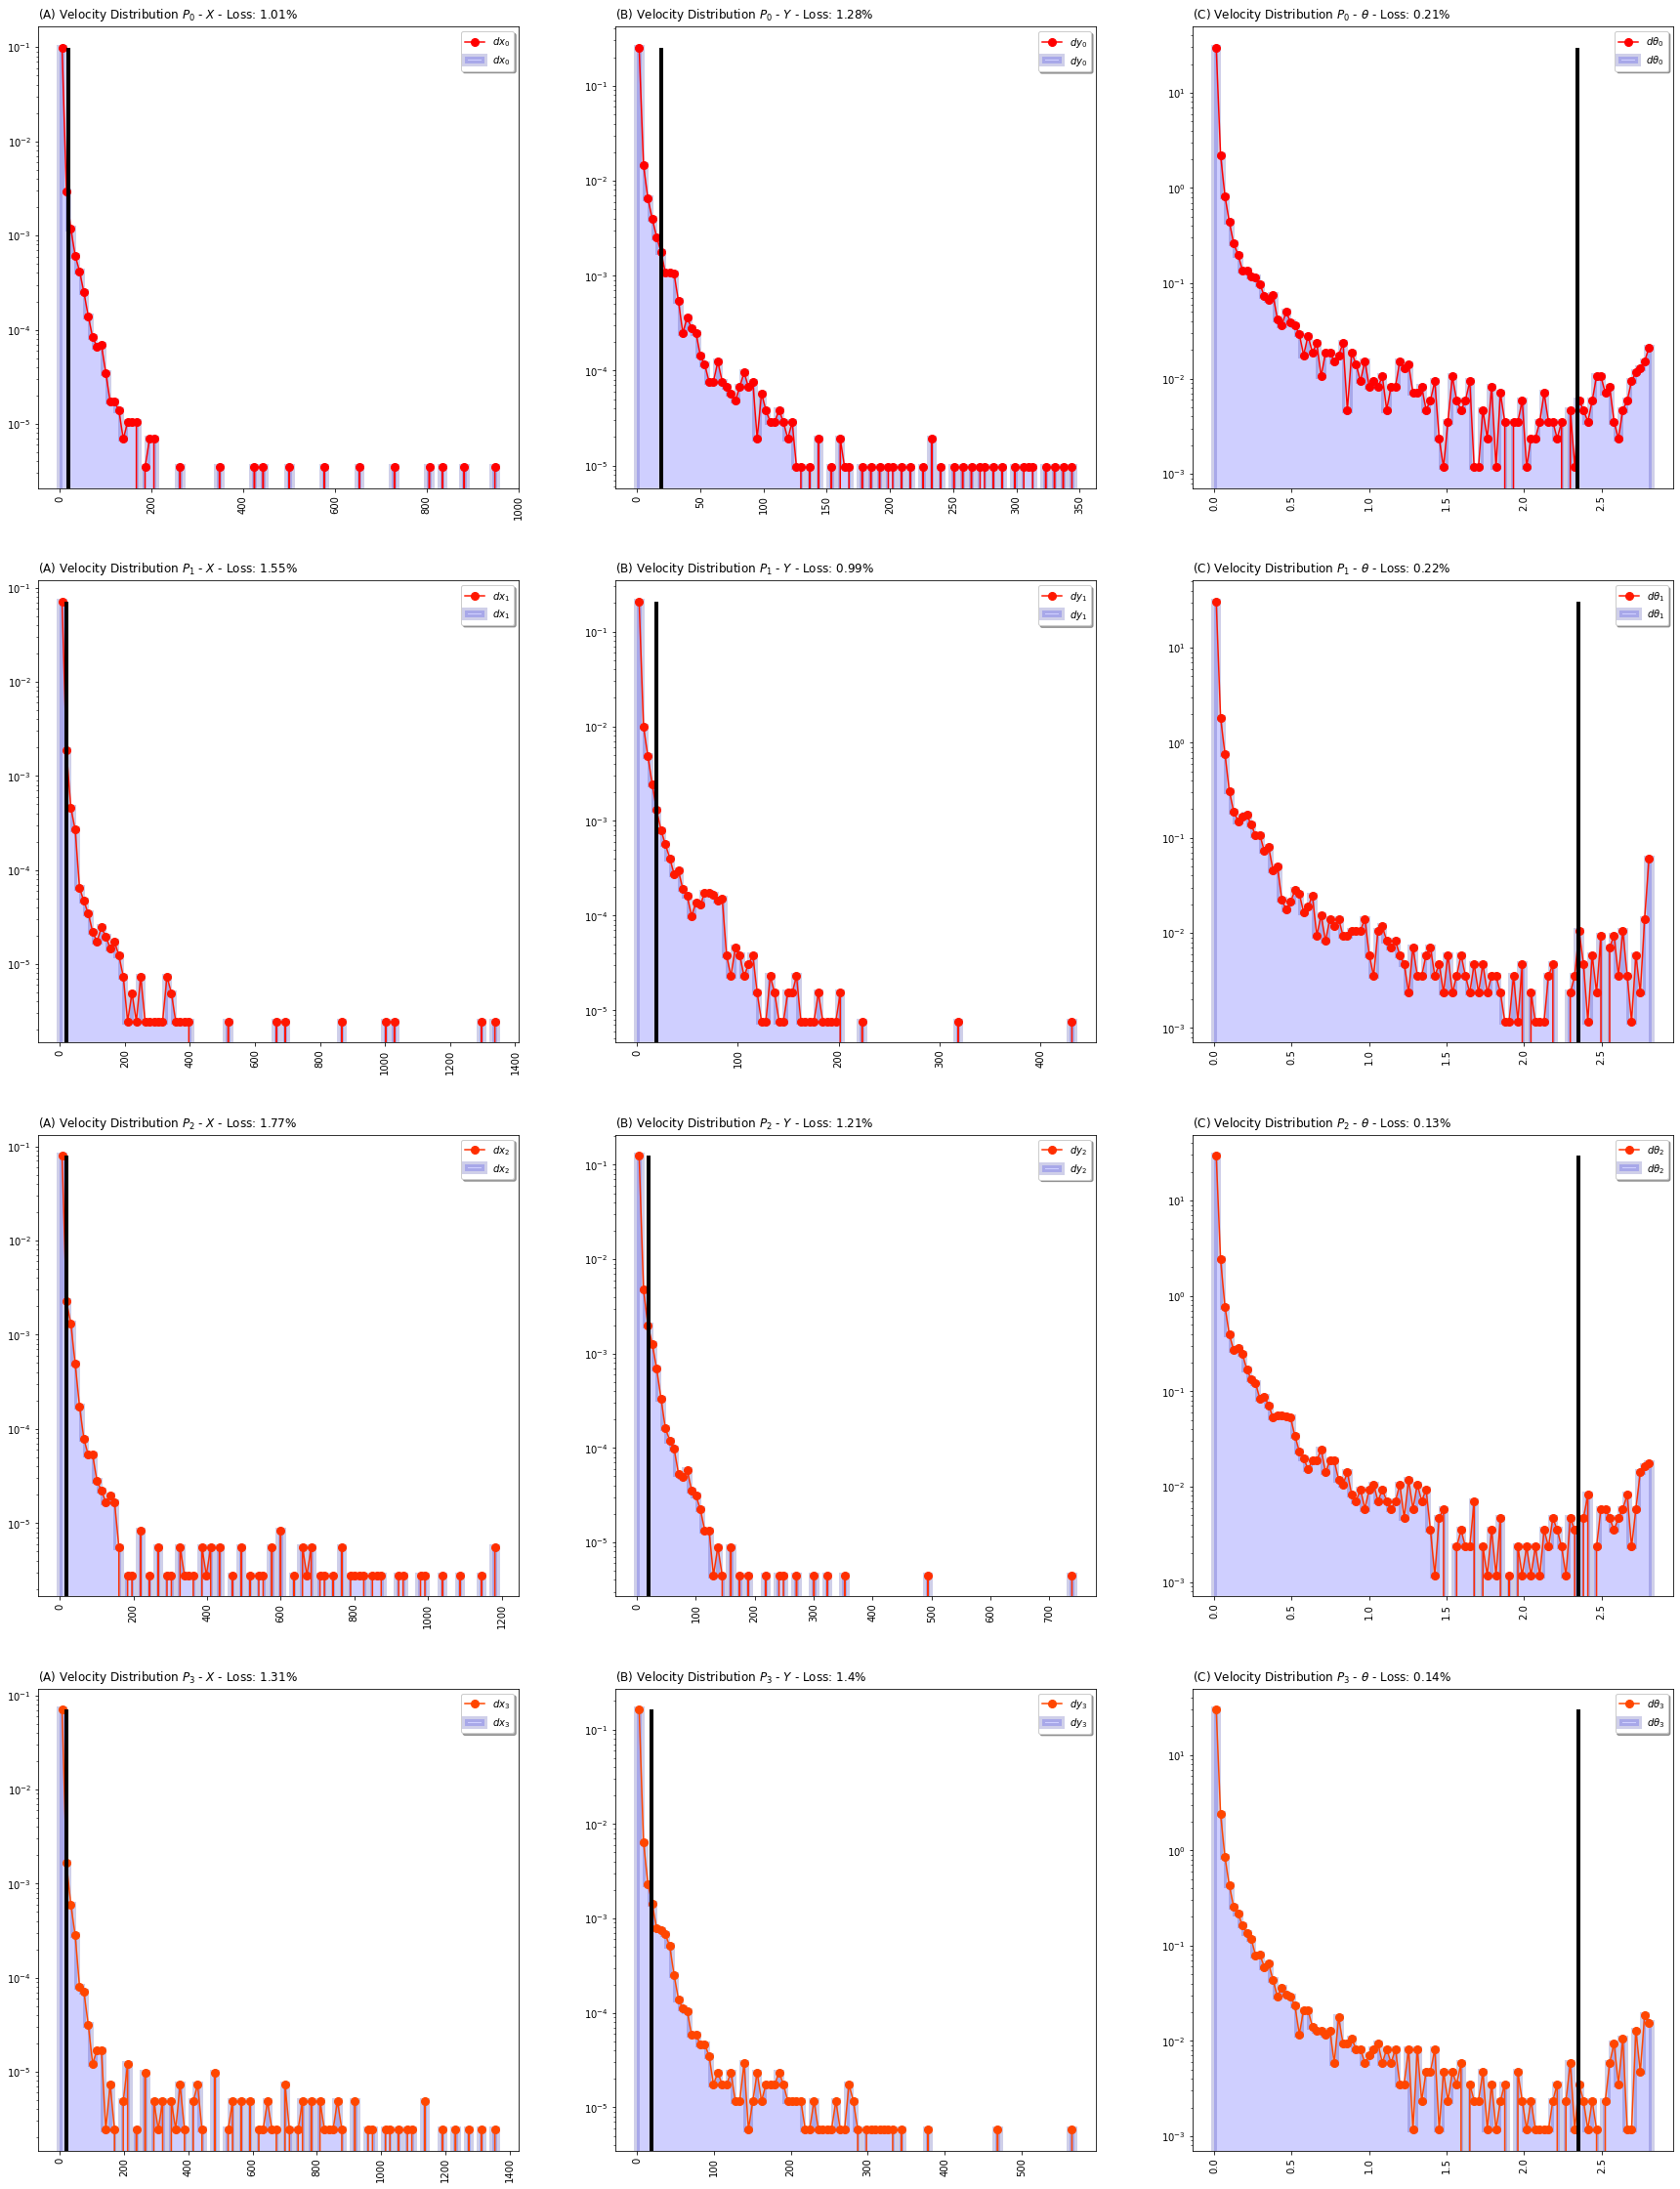

In [60]:
if ordering:
    bins = 100
    width = 10
    fancy_legend = True
    omega_threshold = df_full["velocity_orientation"].abs().quantile(0.9965) # Angular velocity per frame
    velocity_threshold = df_full["velocity_x"].abs().quantile(0.9701) # Velocity per frame limited with half average size of particle
    print("Thresholds:\n\t- Velocity:", velocity_threshold, "\n\t- Angle:", omega_threshold * 180 / np.pi, "\n")

    df_smooth = df_full.copy()
    df_smooth["id"] = df_smooth["permuted_id"]
    plt_cp.plot_velocities_distribution(
        df_tracked=df_smooth,
        bins=bins,
        velocity_threshold=velocity_threshold,
        omega_threshold=omega_threshold,
        width=width,
        fancy_legend=fancy_legend
    )

All


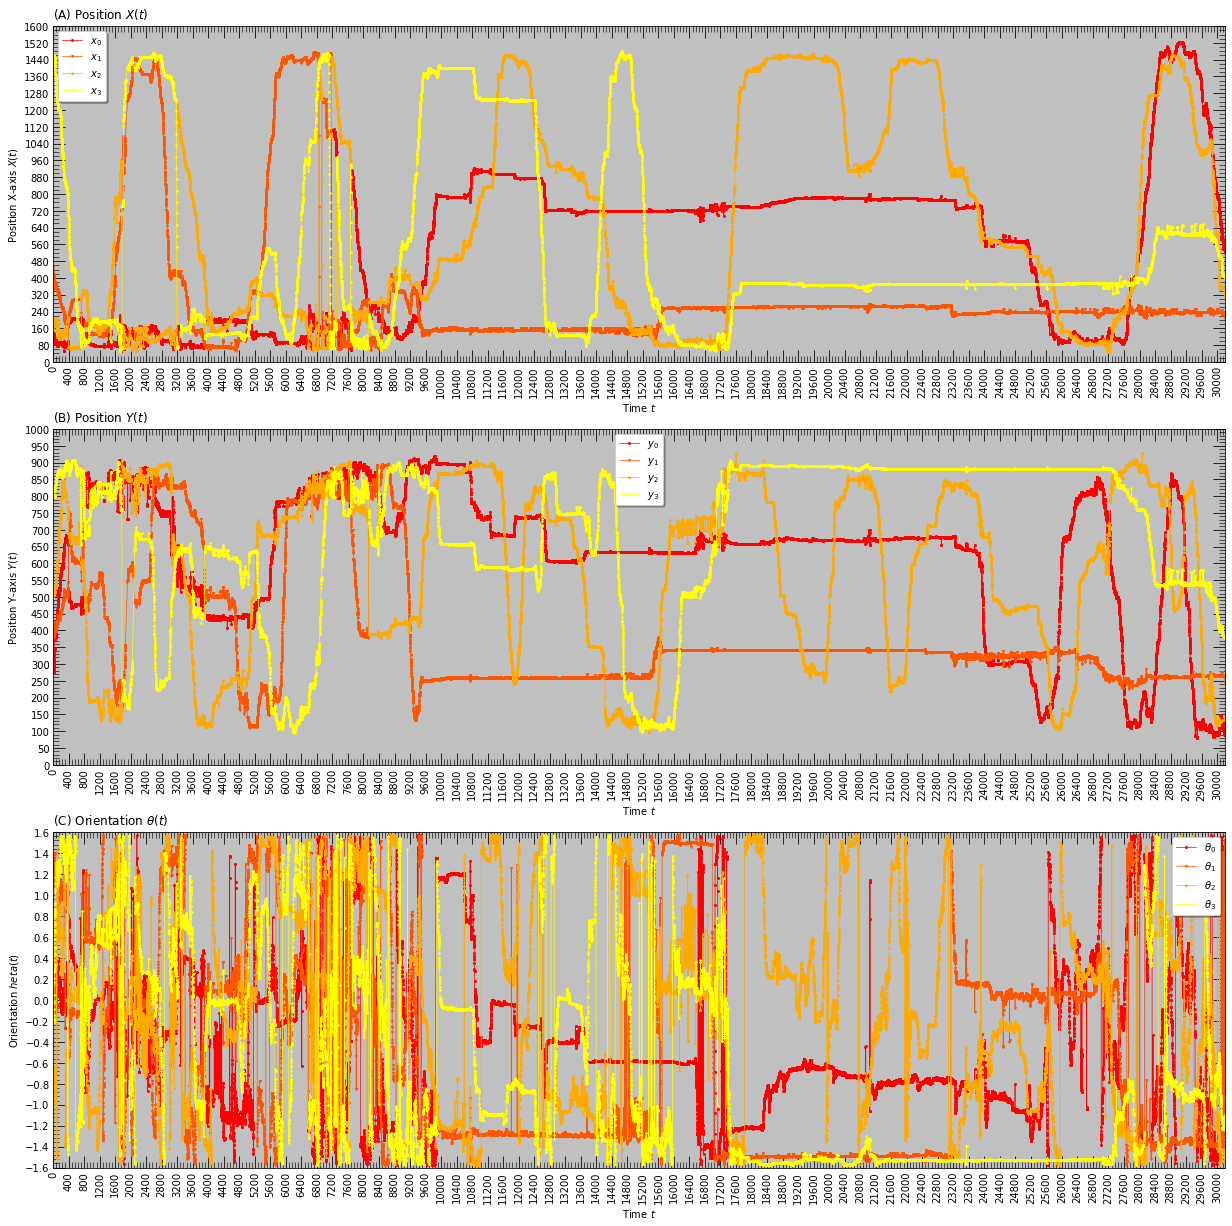

Zoom


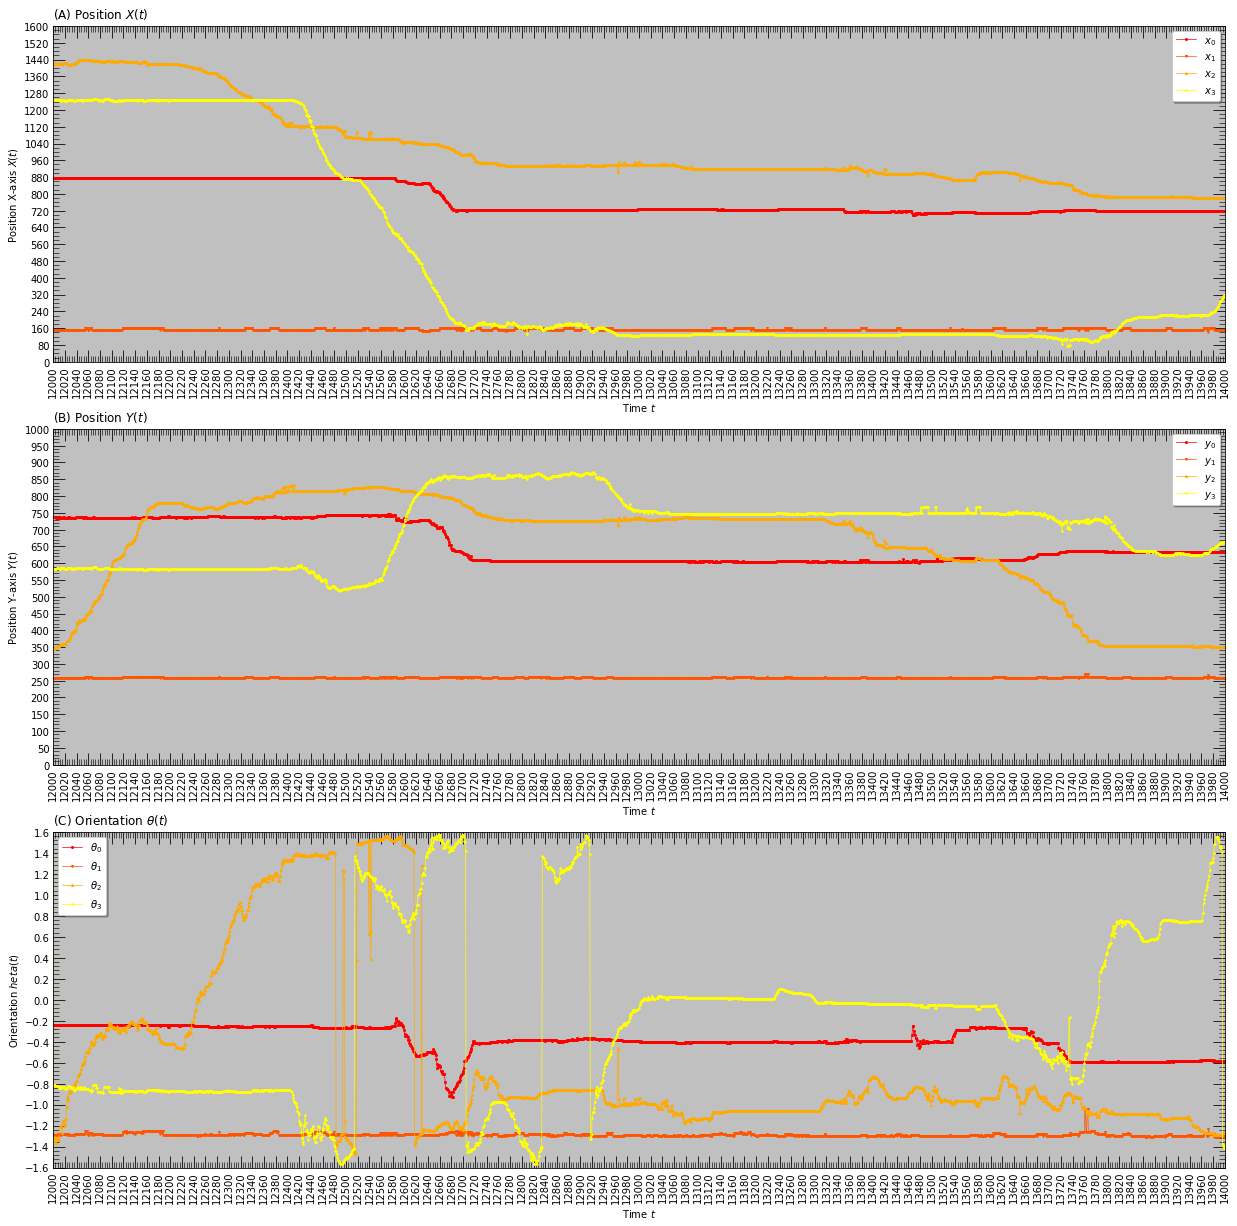

In [62]:
if ordering:
    width = 21
    n_x_breaks = 100
    n_y_breaks = 20
    t0, tf = 0, 30200
    t0_ = 12000
    tf_ = 14000
    t_bounds = [t0_, tf_]
    p_bounds = [[0, 1600], [0, 1000], [-1.6, 1.6]]
    fancy_legend = True
    
    print("All")
    df_smooth = df_full.copy()
    df_smooth["id"] = df_smooth["permuted_id"]
    velocity_threshold = df_full["velocity_x"].abs().quantile(0.9701) # Velocity per frame limited with half average size of particle
    plt_sp.plot_tracking_evolution(
        df_smooth=df_smooth[((df_smooth["velocity_x"] <= velocity_threshold) & (df_smooth["velocity_y"] <= velocity_threshold))],
        width=width,
        n_x_breaks=n_x_breaks,
        n_y_breaks=n_y_breaks,
        t_bounds=[t0, tf],
        p_bounds=p_bounds,
        fancy_legend=fancy_legend
    )
    
    print("Zoom")
    df_smooth = df_full.copy()
    df_smooth["id"] = df_smooth["permuted_id"]
    plt_sp.plot_tracking_evolution(
        df_smooth=df_smooth,
        width=width,
        n_x_breaks=n_x_breaks,
        n_y_breaks=n_y_breaks,
        t_bounds=t_bounds,
        p_bounds=p_bounds,
        fancy_legend=fancy_legend
    )

## Example of smoothed evolution (swap mixed IDs and update orientation)

In [48]:
omega_threshold = df_tracked["velocity_orientation"].abs().quantile(0.9965) # Angular velocity per frame
velocity_threshold = df_tracked["velocity_x"].abs().quantile(0.9852) # Velocity per frame limited with half average size of particle
order=False
t0, tf = 0e2, 4e2  # 0, num_frames
print("Thresholds:\n\t- Velocity:", velocity_threshold, "\n\t- Angle:", omega_threshold * 180 / np.pi)

reload(sp)
df_smooth = sp.smooth_evolution(
    df_tracked=df_tracked[(df_tracked["time"] >= t0) & (df_tracked["time"] <= tf)],
    velocity_threshold=velocity_threshold,
    omega_threshold=omega_threshold,
    order=order
)
df_smooth

Thresholds:
	- Velocity: 18.852874321718346 
	- Angle: 161.61634747228754
Previous Time: 0 Current Time: 1 mask_x: False mask_y: False Final mask: True
Previous Time: 100 Current Time: 101 mask_x: False mask_y: False Final mask: True
Previous Time: 200 Current Time: 201 mask_x: False mask_y: False Final mask: True
Previous Time: 400 Current Time: 401 mask_x: True mask_y: True Final mask: False
Previous Time: 500 Current Time: 501 mask_x: True mask_y: True Final mask: False


,id,time,position_x,position_y,weighted_x,weighted_y,darkest_v,darkest_x,darkest_y,lightest_v,lightest_x,lightest_y,orientation,area,area_convex,area_filled,axis_major,axis_minor,eccentricity,euler_number,id_count,velocity_x,velocity_y,velocity_orientation,mask_x,mask_y,mask_orientation,permuted_id
0,0,0,131.361102,277.047904,129.820192,282.752376,NaN,131.361102,277.047904,NaN,131.361102,277.047904,0.284792,9039.0,12978.0,9050.0,196.579324,71.364684,0.931776,-38,4,NaN,NaN,NaN,False,False,False,0
1,1,0,456.948442,377.037307,457.656262,377.513295,0.0,503.000000,333.000000,0.627451,476.000000,345.000000,1.279919,8631.0,12656.0,8636.0,165.988477,72.910703,0.898364,-22,4,NaN,NaN,NaN,False,False,False,1
2,2,0,164.068444,499.940035,167.470318,504.772246,NaN,164.068444,499.940035,NaN,164.068444,499.940035,-0.738668,9789.0,12576.0,9829.0,187.418000,74.960595,0.916531,-20,4,NaN,NaN,NaN,False,False,False,2
3,3,0,1455.613066,823.843911,1456.773911,830.276236,0.0,1445.000000,738.000000,0.458824,1447.000000,749.000000,-0.155444,9123.0,10618.0,9917.0,190.276157,68.388433,0.933177,-25,4,NaN,NaN,NaN,False,False,False,3
4,0,1,131.236932,278.569644,129.443543,285.456741,NaN,131.236932,278.569644,NaN,131.236932,278.569644,0.282948,9125.0,13383.0,9130.0,200.439365,71.376005,0.934449,-28,4,-0.124170,1.521740,-0.001844,True,True,True,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2399,3,599,279.889522,874.576025,282.817653,874.094790,0.0,231.000000,830.000000,0.631373,361.000000,900.000000,-1.416490,10536.0,13656.0,11178.0,213.651382,78.496466,0.930061,-47,4,-6.491749,-3.209402,0.014157,True,True,True,3
2400,0,600,205.718236,478.215825,205.910322,483.214592,NaN,205.718236,478.215825,NaN,205.718236,478.215825,0.200275,10161.0,14513.0,10171.0,218.093693,75.467612,0.938222,-34,4,-0.146745,0.655101,-0.006254,True,True,True,0
2401,1,600,301.017430,605.973489,301.367714,598.032211,0.0,288.000000,481.000000,0.619608,286.000000,618.000000,-0.152758,9581.0,13120.0,9684.0,222.803304,72.525596,0.945537,-39,4,-0.083637,0.457370,-0.004159,True,True,True,1
2402,2,600,68.809677,676.462156,70.440002,682.276299,0.0,79.000000,589.000000,0.611765,95.000000,597.000000,0.003943,4981.0,14053.0,4997.0,199.163218,68.045830,0.939824,-13,4,-0.051749,-0.356982,0.001611,True,True,True,2


Smoothed


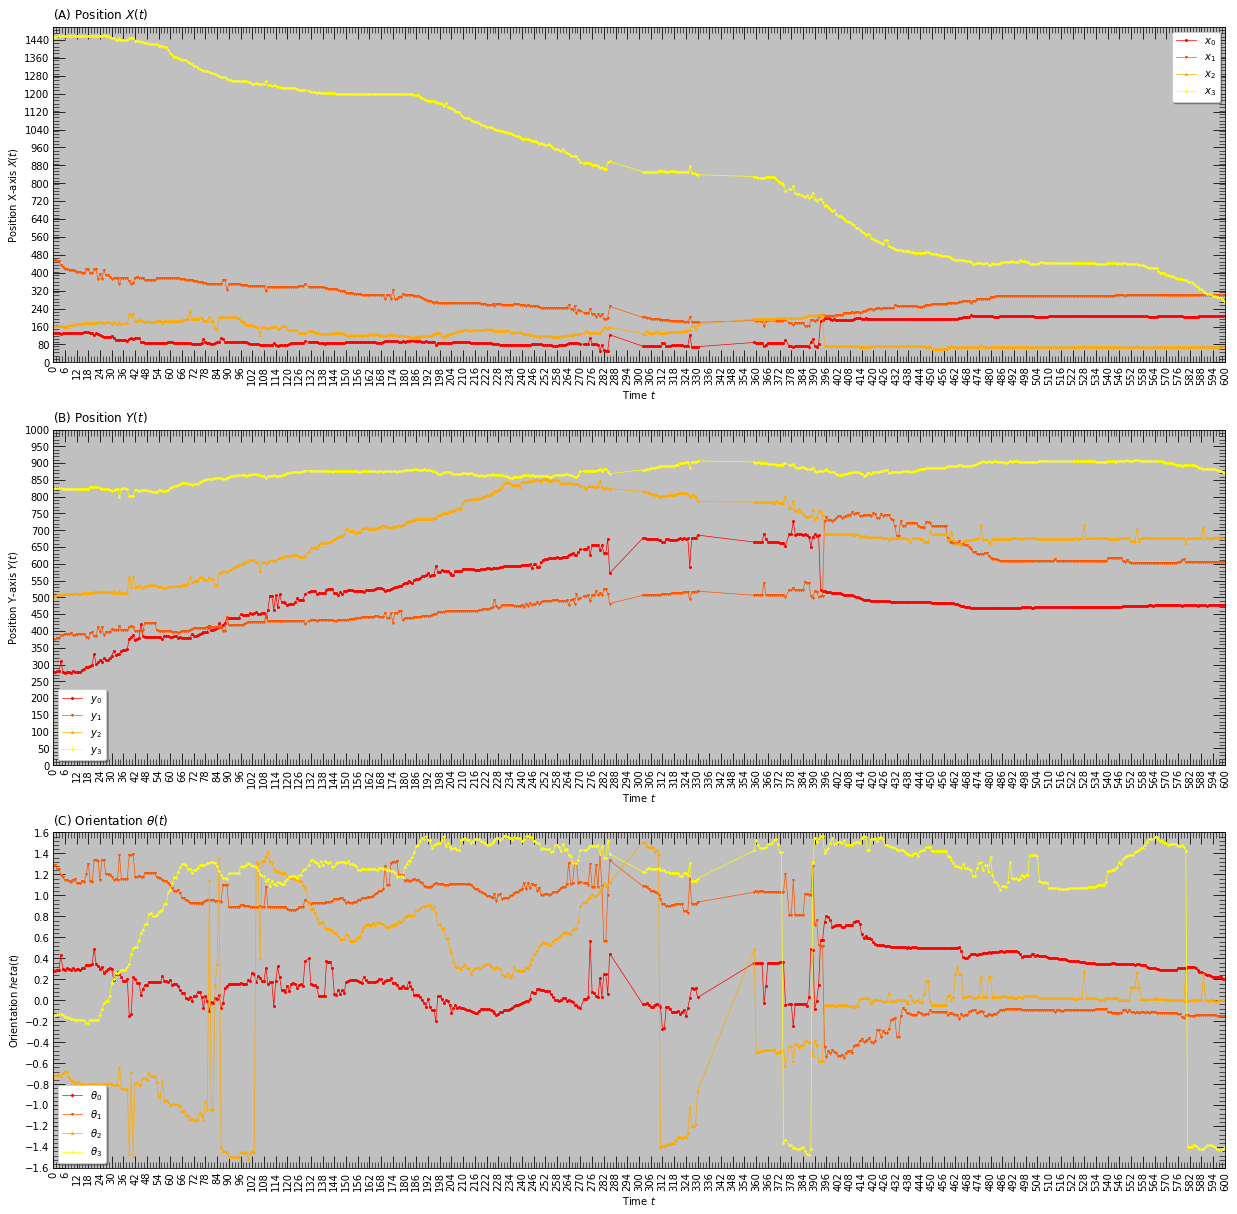

Original


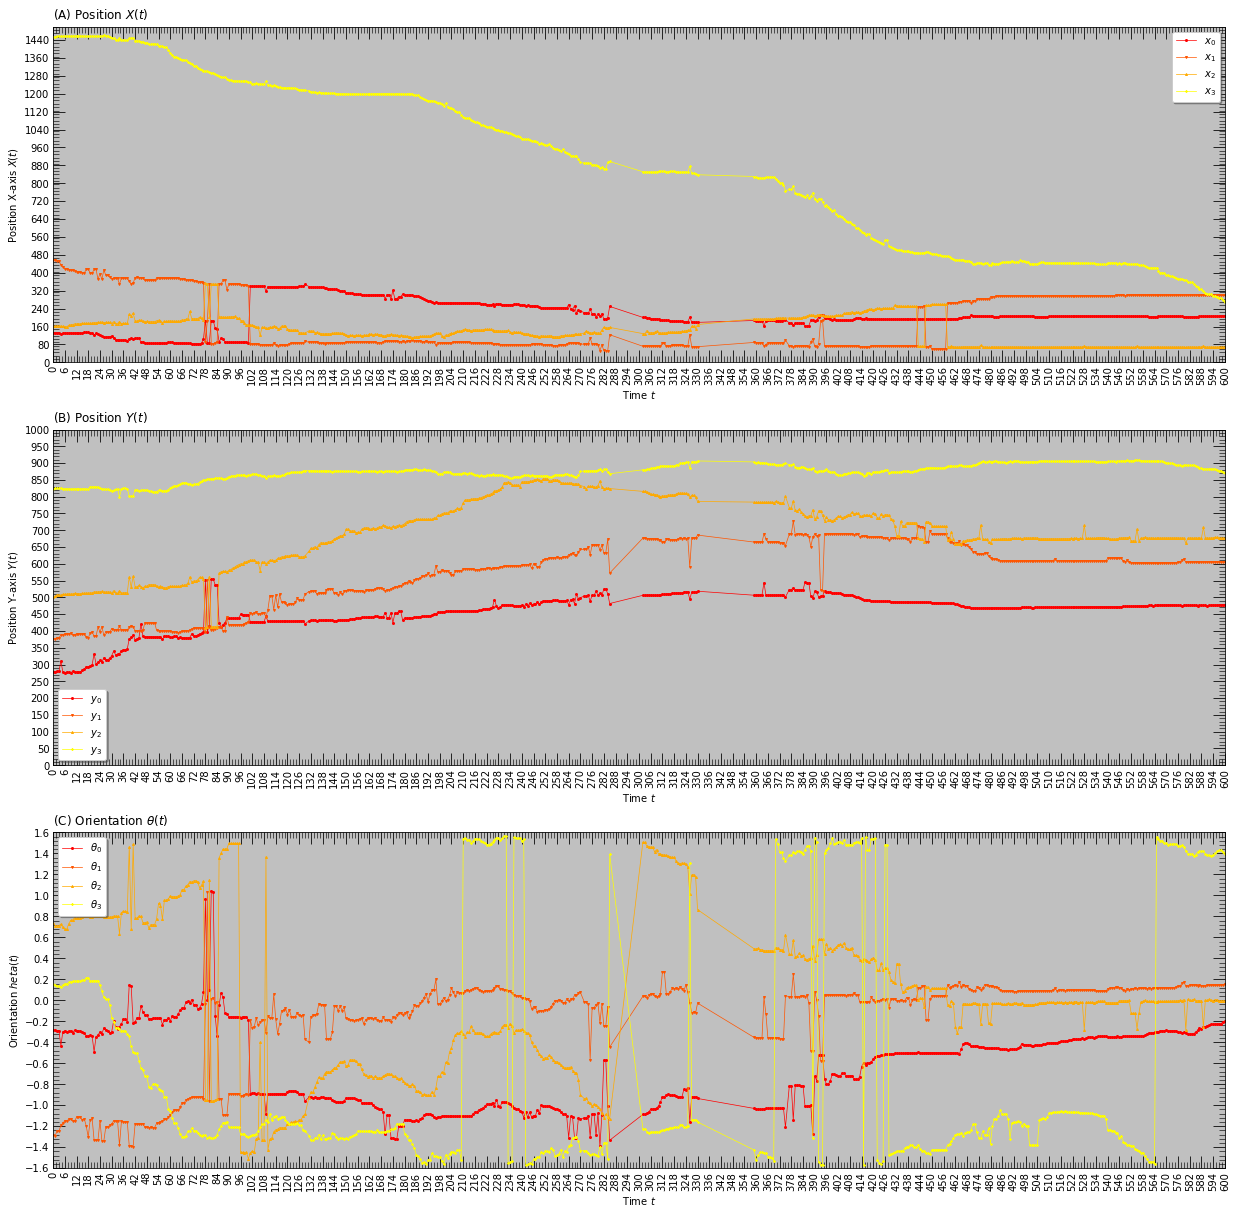

In [49]:
width = 21
n_x_breaks = 100
n_y_breaks = 20
t_bounds = [t0, tf]
p_bounds = [[0, 1500], [0, 1000], [-1.6, 1.6]]
fancy_legend = True

print("Smoothed")
df_smooth["id"] = df_smooth["permuted_id"]
plt_sp.plot_tracking_evolution(
    df_smooth=df_smooth,
    width=width,
    n_x_breaks=n_x_breaks,
    n_y_breaks=n_y_breaks,
    t_bounds=t_bounds,
    p_bounds=p_bounds,
    fancy_legend=fancy_legend
)

print("Original")
plt_sp.plot_tracking_evolution(
    df_smooth=df_tracked,
    width=width,
    n_x_breaks=n_x_breaks,
    n_y_breaks=n_y_breaks,
    t_bounds=t_bounds,
    p_bounds=p_bounds,
    fancy_legend=fancy_legend
)

In [ ]:
bins = 100
width = 10
fancy_legend = True
omega_threshold = df_tracked["velocity_orientation"].abs().quantile(0.965) # Angular velocity per frame
velocity_threshold = df_tracked["velocity_x"].abs().quantile(0.925) # Velocity per frame limited with half average size of particle
print("Thresholds:\n\t- Velocity:", velocity_threshold, "\n\t- Angle:", omega_threshold * 180 / np.pi, "\n")

plt_cp.plot_velocities_distribution(
    df_tracked=df_filter_clustered,
    bins=bins,
    velocity_threshold=velocity_threshold,
    omega_threshold=omega_threshold,
    width=width,
    fancy_legend=fancy_legend
)

### Old data (only clustered)

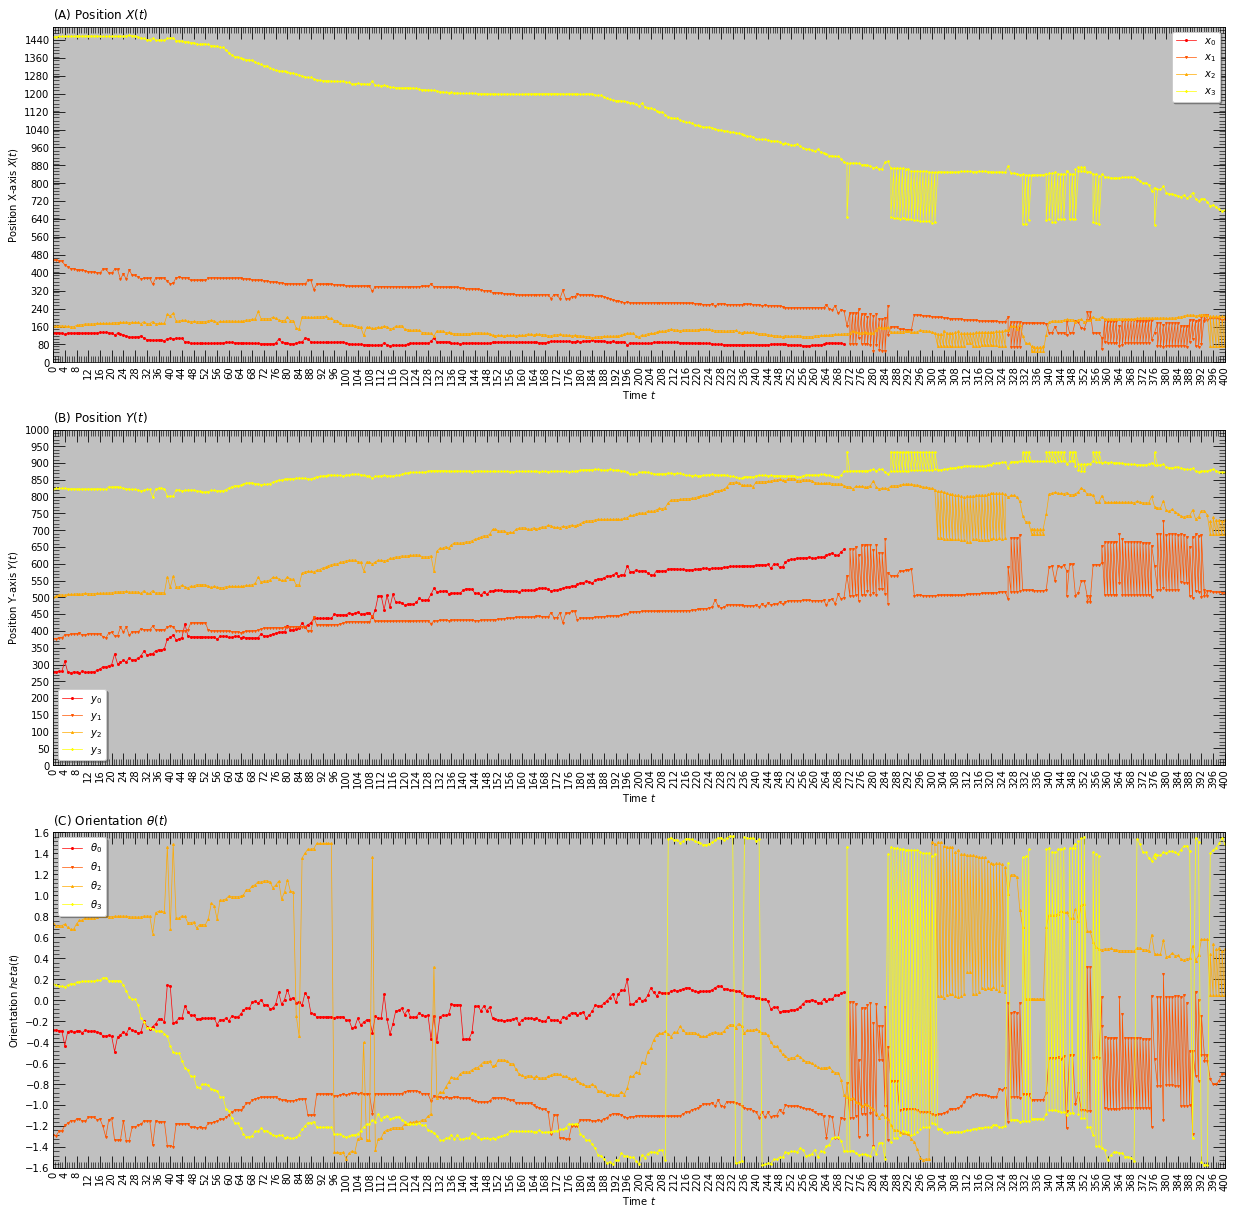

In [70]:
import pandas as pd
import numpy as np
from scipy.spatial.distance import cdist

# Step 1: Create initial DataFrame
A = df_tracked[(df_tracked["time"] >= t0) & (df_tracked["time"] <= tf)]

# Step 2: Initialize a corrected id column
A['corrected_id'] = A['id']

# Step 3: Iterate through consecutive time steps
unique_times = sorted(A['time'].unique())

for i in range(1, len(unique_times)):
    current_time = unique_times[i]
    previous_time = unique_times[i - 1]

    # Extract positions at the current and previous times
    current_df = A[A['time'] == current_time]
    previous_df = A[A['time'] == previous_time]

    # Get positions as arrays for distance calculations
    current_positions = current_df[['position_x', 'position_y']].to_numpy()
    previous_positions = previous_df[['position_x', 'position_y']].to_numpy()
    
    # Step 4: Calculate pairwise distances
    distances = cdist(current_positions, previous_positions, "cityblock")

    # Step 5: Find closest matches for each id at current time
    # Note: `argmin` gives the index of the closest previous id for each current id
    closest_matches = distances.argmin(axis=1)

    # Step 6: Update the 'corrected_id' in the original DataFrame
    current_ids = current_df['id'].values
    previous_ids = previous_df['corrected_id'].values

    # Map each current id to the closest previous id
    new_ids = previous_ids[closest_matches]
    A.loc[A['time'] == current_time, 'corrected_id'] = new_ids

# Display the DataFrame with corrected ids
A[["time", "id", "corrected_id",  "position_x", "position_y", "velocity_x", "velocity_y", "mask_x", "mask_y", "orientation", "velocity_orientation"]].sort_values(["time", "corrected_id"])

A["id"] = A["corrected_id"]
plt_sp.plot_tracking_evolution(
    df_smooth=A,
    width=width,
    n_x_breaks=n_x_breaks,
    n_y_breaks=n_y_breaks,
    t_bounds=t_bounds,
    p_bounds=p_bounds,
    fancy_legend=fancy_legend
)

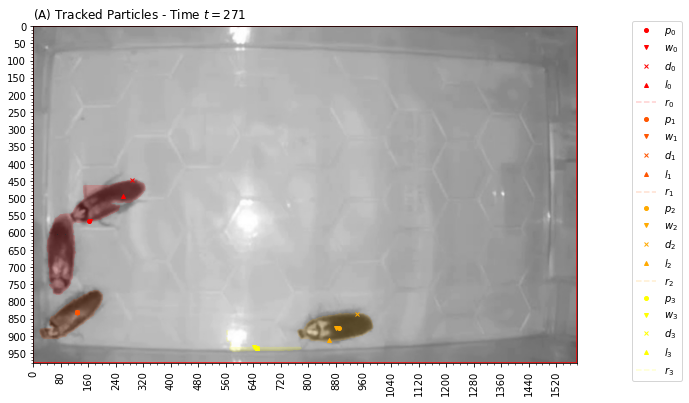

In [55]:
# Original frame
time = 271
reinforce_boundaries = True
remove_holes = False
type = "local equalized"
clip_limit = 0.05
threshold = 0.19
sigma = 1.5
x_bounds = x_bounds  # [40, 1020]
y_bounds = y_bounds  # [160, 1740]
region_area_min = 200
axis_major_min = 94
eccentricity_max = 0.99
width = 10
n_x_breaks = 20
n_y_breaks = 20
x_zoom = None  # x_zoom  # [760, 1000]
y_zoom = None  # y_zoom  # [1500, 1720]
fancy_legend = True
x_legend = 1.001
y_legend = 0.891

df_tracked_frame = tp.process_frame(
    reinforce_boundaries=reinforce_boundaries,
    remove_holes=remove_holes,
    type=type,
    clip_limit=clip_limit,
    threshold=threshold,
    sigma=sigma,
    x_bounds=x_bounds,
    y_bounds=y_bounds,
    region_area_min=region_area_min,
    axis_major_min=axis_major_min,
    eccentricity_max=eccentricity_max,
    tracking_list=[time, reader.get_data(time)]
)

plt_tp.plot_tracking_frame(
    reader=reader,
    time=time,
    df_tracked_frame=df_tracked_frame,
    width=width,
    n_x_breaks=n_x_breaks,
    n_y_breaks=n_y_breaks,
    x_bounds=x_bounds,
    y_bounds=y_bounds,
    x_zoom=x_zoom,
    y_zoom=y_zoom,
    fancy_legend=fancy_legend,
    x_legend=x_legend,
    y_legend=y_legend
)

## TODO

In [ ]:
# Head - Bump Orientation (Postprocess using angle changes of interpolated data)

##### SOLVED #####
# Delete incorrect tracked frames in the algorithm (Manual)
#   Search the persistent long jumps, i.e, after the first permutation if the long jumps persist, drop frame (Automatic)
# Interpolate over deleted IDs